In [1]:
from tqdm import tqdm
import numpy as np
from scipy.linalg import fractional_matrix_power
from scipy.linalg import expm

from scipy.stats import norm
from matplotlib import pyplot as plt
from glob import glob
import pandas as pd
import random

# Definition of the NTKgp

In [2]:
#sigma_w = np.sqrt(1.5)
#sigma_b = 1.
Mu = 0.
STD = 1.
input_size = 1
#eta = 0.1
#n0 = 1
#depth = 3

#time = 1000

For the activation function $\phi = {\rm erf}$, we have:

In [3]:
def mathT(a, b, c, d):
    return 2./np.pi * np.arcsin( 2.* b / np.sqrt((1+2*a)*(1+2*d)))

def mathTp(a, b, c, d):
    #det = a*c - b*d
    auxMat = np.empty((2,2))
    auxMat[0,0] = a
    auxMat[0,1] = b
    auxMat[1,0] = c
    auxMat[1,1] = d
    return 4./ np.pi * np.linalg.det(fractional_matrix_power(np.eye(2) + 2*auxMat, -1./2.))
    #return 4./ np.pi / (np.linalg.det(np.eye(2) + 2*auxMat))**2.

For the activation function ReLU $\phi(x) = \max(x, 0)$, we have:

In [4]:
def mathT(a, b, c, d):
    a = np.linalg.norm(a)
    d = np.linalg.norm(d)
    fact_or = b/np.sqrt(a*d)
    output = np.sin(np.arccos(fact_or)) + (np.pi - np.arccos(fact_or))*fact_or
    return 1./2./np.pi * np.sqrt(a*d) * output


def mathTp(a, b, c, d):
    a = np.linalg.norm(a)
    d = np.linalg.norm(d)
    return 1./2./np.pi * (np.pi - np.arccos(b/np.sqrt(a*d)))

In [5]:
def Kappa(arr1, arr2, l_index, sigma_w, sigma_b, n0):
    if l_index == 1:
        return np.dot(arr1,arr2)/n0*sigma_w**2. + sigma_b**2.
    else:
        T11 = Kappa(arr1, arr1, l_index-1, sigma_w, sigma_b, n0)
        T12 = Kappa(arr1, arr2, l_index-1, sigma_w, sigma_b, n0)
        T21 = T12
        T22 = Kappa(arr2, arr2, l_index-1, sigma_w, sigma_b, n0)
        return sigma_w**2.*mathT(T11, T12, T21, T22) + sigma_b**2.

    
    
def Theta(arr1, arr2, l_index, sigma_w, sigma_b, n0):
    if l_index == 1:
        return np.dot(arr1,arr2)/n0*sigma_w**2. + sigma_b**2.
    else:
        T11 = Kappa(arr1, arr1, l_index-1, sigma_w, sigma_b, n0)
        T12 = Kappa(arr1, arr2, l_index-1, sigma_w, sigma_b, n0)
        T21 = T12
        T22 = Kappa(arr2, arr2, l_index-1, sigma_w, sigma_b, n0)
        return sigma_w**2.*mathTp(T11, T12, T21, T22)*Theta(arr1, arr2, l_index-1, sigma_w, sigma_b, n0)

In [6]:
#def distribNTKgp(time, x, input_train, output_train, eta, n_layer, sigma_w, sigma_b, n0):
def distribNTKgp(x, input_train, output_train, eta, n_layer, sigma_w, sigma_b, n0):
    tdim = len(input_train)
    Kxx = Kappa(x, x, n_layer+1, sigma_w, sigma_b, n0)
    KxCalX = np.empty((tdim))
    TxCalX = np.empty((tdim))
    KCalXCalX = np.empty((tdim, tdim))
    TCalXCalX = np.empty((tdim, tdim))
    
    for index, elem in enumerate(input_train):
        KxCalX[index] = Kappa(x, elem, n_layer+1, sigma_w, sigma_b, n0)
        TxCalX[index] = Theta(x, elem, n_layer+1, sigma_w, sigma_b, n0)
        for jndex in range(index,tdim):
            KCalXCalX[index, jndex] = Kappa(elem, input_train[jndex], n_layer+1, sigma_w, sigma_b, n0)
            KCalXCalX[jndex, index] = KCalXCalX[index, jndex]
            TCalXCalX[index, jndex] = Theta(elem, input_train[jndex], n_layer+1, sigma_w, sigma_b, n0)
            TCalXCalX[jndex, index] = TCalXCalX[index, jndex]

    T_inverse = np.linalg.inv(TCalXCalX)
    Aux = np.eye(tdim) #- expm(-eta*TCalXCalX*time)
    
    mean = np.matmul(TxCalX, np.matmul(T_inverse, np.matmul(Aux, output_train)))
    variance = Kxx + np.matmul(TxCalX, np.matmul(T_inverse, np.matmul(Aux, np.matmul(KCalXCalX, np.matmul(Aux, np.matmul(T_inverse, TxCalX))))))
    vaux = np.matmul(TxCalX, np.matmul(T_inverse, np.matmul(Aux, KxCalX)))
    variance -= vaux + np.conj(vaux)
    return mean, np.sqrt(abs(variance))

In [7]:
def distribNNGP(x, input_train, output_train, eta, n_layer, sigma_w, sigma_b, n0):
    tdim = len(input_train)
    Kxx = Kappa(x, x, n_layer+1, sigma_w, sigma_b, n0)
    KxCalX = np.empty((tdim))
    KCalXCalX = np.empty((tdim, tdim))
    
    for index, elem in enumerate(input_train):
        KxCalX[index] = Kappa(x, elem, n_layer+1, sigma_w, sigma_b, n0)
        for jndex in range(index,tdim):
            KCalXCalX[index, jndex] = Kappa(elem, input_train[jndex], n_layer+1, sigma_w, sigma_b, n0)
            KCalXCalX[jndex, index] = KCalXCalX[index, jndex]
            
    K_inverse = np.linalg.inv(KCalXCalX)
    #Aux = expm(-eta*KCalXCalX*time)
    Aux1 = np.eye(tdim)# - np.matmul(Aux,Aux)
    Aux = np.eye(tdim)# - Aux
    #print(Aux, output_train)
    mean = np.matmul(KxCalX, np.matmul(K_inverse, np.matmul(Aux, output_train)))
    variance = Kxx - np.matmul(KxCalX, np.matmul(K_inverse, np.matmul(Aux1, KxCalX.T)))
    
    return mean, np.sqrt(variance)

## Inverse Problem for the Correlators 

### Fake Correlator Data

In [8]:
pattern = "fakedata/Data_*.txt*"

data_files = glob(pattern)

#random.shuffle(data_files)

tot_max = len(data_files)
boot_max = 1000 # tot_max

Ntotdata = len(np.loadtxt(data_files[0], unpack=True))
# df = pd.read_csv(data_files[0], header=None, names=['Value'])
time_max = 200
num_samples = 1000

input = np.ndarray(shape = (tot_max, time_max))
output = np.ndarray(shape = (tot_max, num_samples))

#for ind,file in enumerate(data_files):
for ind in range(0,tot_max):
    #x_temp = np.loadtxt(file, unpack=True)
    x_temp = np.loadtxt(data_files[ind], unpack=True)
    input[ind] = x_temp[0:time_max]
    output[ind] = x_temp[Ntotdata-num_samples:]

print(len(output[boot_max-1]), boot_max)    
    
num_train = boot_max - 1
num_test = boot_max - 1 # boot_max - 1

input_train = input[0:num_train,:]
input_test = input[num_test,:]


out_train = output[0:num_train,:]
out_test = output[num_test,:]



1000 1000


In [9]:
print(data_files[0:1000])

['fakedata/Data_517_3Bis.txt', 'fakedata/Data_836_3Bis.txt', 'fakedata/Data_767_3Bis.txt', 'fakedata/Data_180_3Bis.txt', 'fakedata/Data_104_3Bis.txt', 'fakedata/Data_44_1Bis.txt', 'fakedata/Data_708_3Bis.txt', 'fakedata/Data_946_3Bis.txt', 'fakedata/Data_799_3Bis.txt', 'fakedata/Data_0_3Bis.txt', 'fakedata/Data_846_3Bis.txt', 'fakedata/Data_68_1Bis.txt', 'fakedata/Data_55_1Bis.txt', 'fakedata/Data_912_3Bis.txt', 'fakedata/Data_339_3Bis.txt', 'fakedata/Data_88_3Bis.txt', 'fakedata/Data_439_3Bis.txt', 'fakedata/Data_166_3Bis.txt', 'fakedata/Data_59_1Bis.txt', 'fakedata/Data_80_1Bis.txt', 'fakedata/Data_450_3Bis.txt', 'fakedata/Data_17_3Bis.txt', 'fakedata/Data_889_3Bis.txt', 'fakedata/Data_397_3Bis.txt', 'fakedata/Data_117_3Bis.txt', 'fakedata/Data_686_3Bis.txt', 'fakedata/Data_266_3Bis.txt', 'fakedata/Data_956_3Bis.txt', 'fakedata/Data_269_3Bis.txt', 'fakedata/Data_827_3Bis.txt', 'fakedata/Data_874_3Bis.txt', 'fakedata/Data_139_3Bis.txt', 'fakedata/Data_742_3Bis.txt', 'fakedata/Data_51_

### Harmonic Oscillator Data

In [10]:
boot, time, corr = np.loadtxt("bootstrap/bootstrap_primofile.dat", unpack=True)

time_max = int(np.max(time) + 1)
boot_max = int(np.max(boot))

num_train = boot_max - 1
num_test = int(boot_max/2) #boot_max-1 #boot_max - num_train

input = np.ndarray(shape = (boot_max, time_max))
for ind, elem in enumerate(input):
    auxind = ind * time_max
    input[ind] = np.array([corr[ii + auxind] for ii in range(0,time_max)])

#input_train = input[0:num_train,:]
input_test = input[num_test,:]
    
num_samples = 1000
x = np.linspace(0, 20, num_samples)
etaharm = 0.05
smear_sigma = 0.1

pdf = norm.pdf(x, loc = etaharm, scale = smear_sigma)
##plt.plot(x, pdf)
##plt.show()

#out_train = np.ndarray(shape = (num_train, num_samples))
#for ii in range(0, num_train):
#    out_train[ii] = 1./2./np.sqrt(np.pi*smear_sigma)*pdf

In [11]:
#print(out_train, len(input), input[boot_max-1][time_max-1])

sigma_b = 0.2
sigma_w = 0.1

n0 = time_max
eta = 0.1
n_layer = 3

#input_test = np.array([1.]*time_max)

out_net = distribNTKgp(input_test, input_train, out_train, eta, n_layer, sigma_w, sigma_b, n0)

#out_net = distribNNGP(input_test, input_train, out_train, eta, n_layer, sigma_w, sigma_b, n0)

#input_train = input[0:num_train,:]
#input_test = input[len(N)-1,:]
#for ind, elem in enumerate(input):
#    if ind == num_train:
#        print(elem)

#Mxout_train = Mx[0:num_train]
#Mxout_test = Mx[num_train:len(N)]

#print(input_test, Mxout_test, len(N))


5.2272253971238464e+75 200


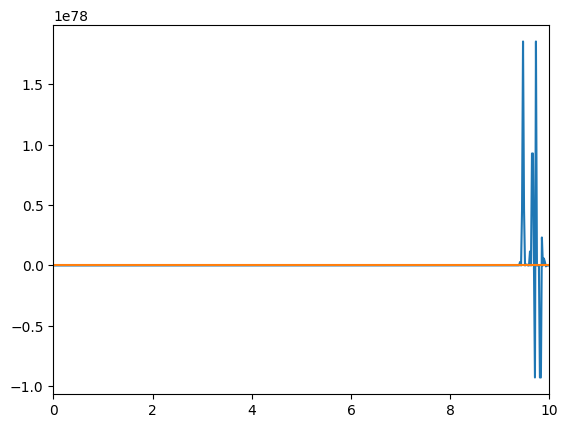

In [12]:
print(out_net[1], len(input_test))
plt.plot(x, out_net[0])
plt.xlim([0,10])
plt.plot(x, pdf)#out_test)
plt.show()


## Stock Price Data

In [254]:
def get_real_data_single(sym,start_t=None,end_t=None):
    pd.set_option('use_inf_as_na',True)
    if start_t!=None and type(start_t)==str:
        start_t=np.datetime64(start_t).astype('datetime64[ns]').astype(int)/(1e9*3600*24)
    if end_t!=None and type(end_t)==str:
        end_t=np.datetime64(end_t).astype('datetime64[ns]').astype(int)/(1e9*3600*24)
    
    df = pd.read_csv(f"../../fin_corr/data/equities_volume/{sym}.dat", header=None, sep=" ").dropna()
    header=df.iloc[0,:]
    min_time=header.iloc[1]
    max_time=header.iloc[2]
    df=df.drop(index=0)
    df = df.rename(columns={0: 'time', 1: 'open', 2: 'vol'})
    if start_t!=None and end_t==None:
        df=df.loc[(df['time']>=start_t),:]
    elif start_t==None and end_t!=None:
        df=df.loc[(df['time']<end_t),:]
    elif start_t!=None and end_t!=None:
        df=df.loc[(df['time']>=start_t)&(df['time']<end_t),:]
    length=len(df.iloc[:])
    path_dict={'symbol':sym,'len':length,'times':df.iloc[:,0].to_numpy(),'open':df.iloc[:,1].to_numpy(),'vol':df.iloc[:,2].to_numpy()}
    
    return path_dict

def get_real_data(start_title,end_title,start_t=None,end_t=None):
    #outfolder="../data/equities_volume"
    all_symbols_array = pd.read_csv(f"../../fin_corr/data/all_equities_symbols_sorted.txt", header=None, sep=" ").to_numpy()
    titles = all_symbols_array[start_title:end_title,0]
    
    paths_dicts=[]
    for sym in titles:
        paths_dicts.append(get_real_data_single(sym,start_t,end_t))
    return paths_dicts

100
IBM   time:  82.82828282828282  vol_max:  13623100.0  variation(max4):  [-0.280006   -0.059998    0.150001    2.050003    1.509995    1.60333267
  1.69667033]
100
FL   time:  20.2020202020202  vol_max:  26665600.0  variation(max4):  [ 0.93      0.740002 -0.29     -1.200001 -1.186667 -1.173333 -1.159999]


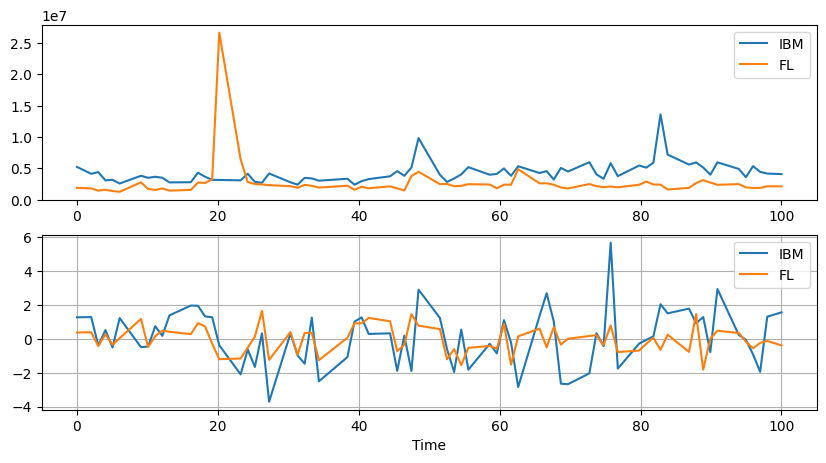

In [263]:
tmax_train=np.datetime64('2023-07-30').astype('datetime64[ns]').astype(int)/(1e9*3600*24)
tmin_train=np.datetime64('2022-07-30').astype('datetime64[ns]').astype(int)/(1e9*3600*24)
assert(tmax_train > tmin_train)

start_title=0
num_titles=2
end_title=start_title+num_titles
paths_list = get_real_data(start_title,end_title,start_t=tmin_train,end_t=tmax_train)
num_paths=num_titles

fig, ax = plt.subplots(2,1,figsize=(10,5))

for m,ptd in enumerate(paths_list):
    time_steps=ptd['times']
    opath = ptd['open']
    vpath=ptd['vol']
    
    time_steps = time_steps[0:100]
    opath = opath[0:100]
    vpath = vpath[0:100]
    
    time_steps = (time_steps - np.min(time_steps))/(np.max(time_steps)- np.min(time_steps))*time_max
    #num_points = time_max
    #step = len(time_steps) // num_points
    ## Select equidistant points using slicing
    #time_steps = time_steps[::step]
    #opath = opath[::step]
    #vpath = vpath[::step]
    print(len(opath))
    
    ax[0].plot(time_steps, vpath, label=ptd['symbol'])
    ax[1].plot(time_steps, opath, label=ptd['symbol'])
    if m >= 0:
        indx_volmax = np.argmax(vpath)
    print(ptd['symbol'], '  time: ', time_steps[indx_volmax], ' vol_max: ', np.max(vpath), ' variation(max4): ', opath[indx_volmax-3:indx_volmax+4])

ax[0].legend()
ax[1].legend()
plt.xlabel("Time")
plt.grid(True)
plt.show()